In [108]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## Data
`data/CT_composite.csv` (below) is the output of `merge_connecticut_econ_data.ipynb` and contains year-by-year economic data as well as year-by-year overdose deaths for each Connecticut county.

This file in turn relies on data processed in two other files:
* `clean_census_income_data.ipynb` converts spacing-indexed TXT files from the U.S. Census Bureau into CSV files with the desired data.
* `deaths_data.ipynb` converts a list of accidental drug overdose deaths in Connecticut between 2012 and 2018 into county-by-county data (after filling missing county values using geolocation data)

It also merges population data from an additional U.S. Census source file so that per capita numbers can be calculated.

In [5]:
# import compiled data
composite_info = pd.read_csv('data/CT_composite.csv')
composite_info.head(4)

,Unnamed: 0,Jurisdiction,Year,MedianHouseholdIncome,%inPoverty,TotalInPoverty,%MinorsInPoverty,TotalMinorsInPoverty,%Unemployed,Population,povNorm,povMinorsNorm,unempNorm,incomeNorm,DeathsInCounty,ResidentDeaths,PerCapDeathsInCounty,PerCapResidentDeaths,DeathsInCountyNorm,ResidentDeathsNorm
0,0,Connecticut,2012,67275,10.6,370537,14.6,114613,8.349387,3594547,100,100,100,100,355.0,347.0,0.000099,0.000097,100.000000,100.000000
1,1,Fairfield,2012,79536,8.9,81756,11.1,24854,7.800000,935099,83,76,93,118,52.0,51.0,0.000056,0.000055,56.306893,56.497246
2,2,Hartford,2012,63374,12.2,106357,16.7,32889,8.500000,897706,115,114,101,94,101.0,92.0,0.000113,0.000102,113.920809,106.161829
3,3,Litchfield,2012,67746,7.0,12975,8.6,3272,7.600000,187570,66,58,91,100,17.0,20.0,0.000091,0.000107,91.770132,110.453965


## Accidental Overdose Deaths in Connecticut

Deaths from accidental drug overdose rose overall in Connecticut during the period reported, and also rose in each county.

Unsurprisingly, the three counties whose populations are highest (by a significant margin over the remaining five) are largest in terms of raw numbers.

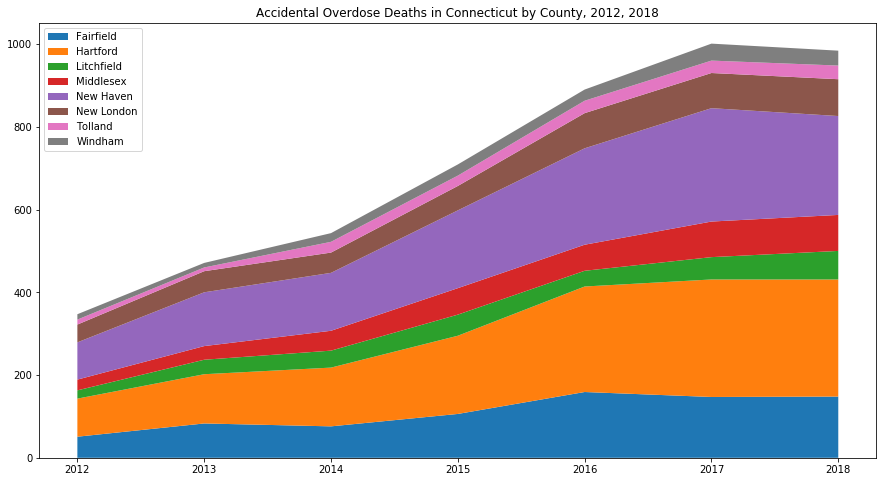

In [100]:
def residentDeaths_stack():
    year_frame = []
    for jurisdiction in list(composite_info["Jurisdiction"].unique()):
        if jurisdiction != "Connecticut":
            df = composite_info[composite_info["Jurisdiction"] == jurisdiction][["Year","ResidentDeaths"]].set_index("Year").rename(columns={"ResidentDeaths": jurisdiction})
            if len(year_frame) > 0:
                year_frame = year_frame.join(df)
            else:
                year_frame = df
            
    plt.figure(figsize=(15,8))
    plt.title('Accidental Overdose Deaths in Connecticut by County, 2012, 2018')
    plt.stackplot(year_frame.index, year_frame.values.T, labels=year_frame.columns)
    plt.legend(loc='upper left')
    
residentDeaths_stack()

Simultaneously, unemployment actually dropped significantly statewide over the same time period.

Meanwhile, the poverty rate did not show a similarly consistent pattern. It fluctuated significantly in Middlessex and New London counties, and showed a 5-10% increase over the reported period in Middlesex, Fairfield, Tolland, and New London counties.

### Deaths Per Capita

Per capita rates of accidental overdose death among residents (normalized to the statewide rate at 100) tell a different story, with smaller counties like Litchfield and New London posting numbers significantly higher than average in multiple years. Fairfield, meanwhile, posted consistently lower per capita rates.

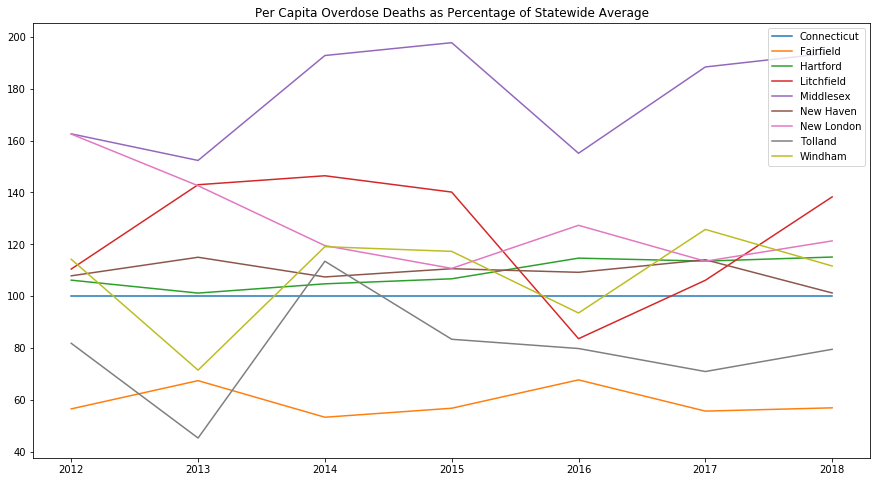

In [109]:
def residentDeathsNorm():
    plt.figure(figsize=(15,8))
    plt.title("Per Capita Resident Overdose Deaths as Percentage of Statewide Average")
    for jurisdiction in list(composite_info["Jurisdiction"].unique()):
        df = composite_info[composite_info["Jurisdiction"] == jurisdiction]
        plt.plot(df["Year"], df["ResidentDeathsNorm"], label=jurisdiction)
    plt.legend()
    
residentDeathsNorm()

A graph of deaths that occurred within each county (adjusted per capita) shows similar patterns:

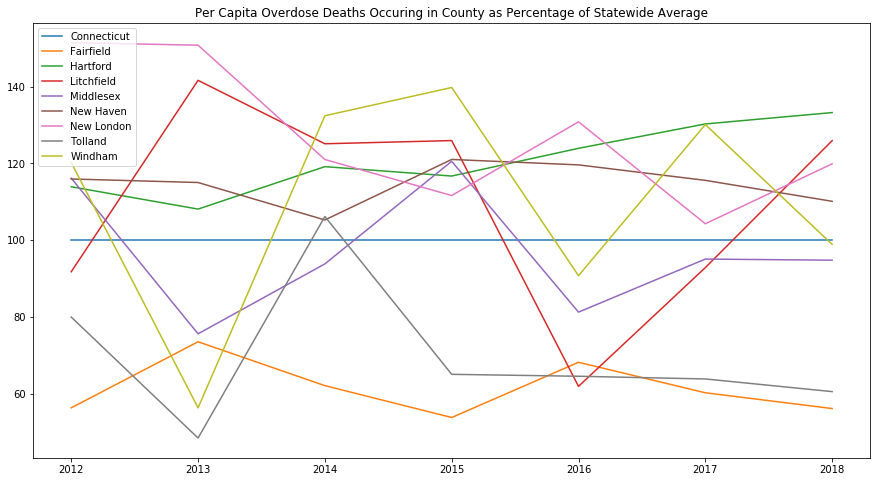

In [112]:
def deathsInCountyNorm():
    plt.figure(figsize=(15,8))
    plt.title("Per Capita Overdose Deaths Occuring in County as Percentage of Statewide Average")
    for jurisdiction in list(composite_info["Jurisdiction"].unique()):
        df = composite_info[composite_info["Jurisdiction"] == jurisdiction]
        plt.plot(df["Year"], df["DeathsInCountyNorm"], label=jurisdiction)
    plt.legend()
        
deathsInCountyNorm()

## County Deaths and Economic Data

Comparing economic data to death rates does not show clear patterns.

Unemployment actually dropped significantly statewide over the reported time period.

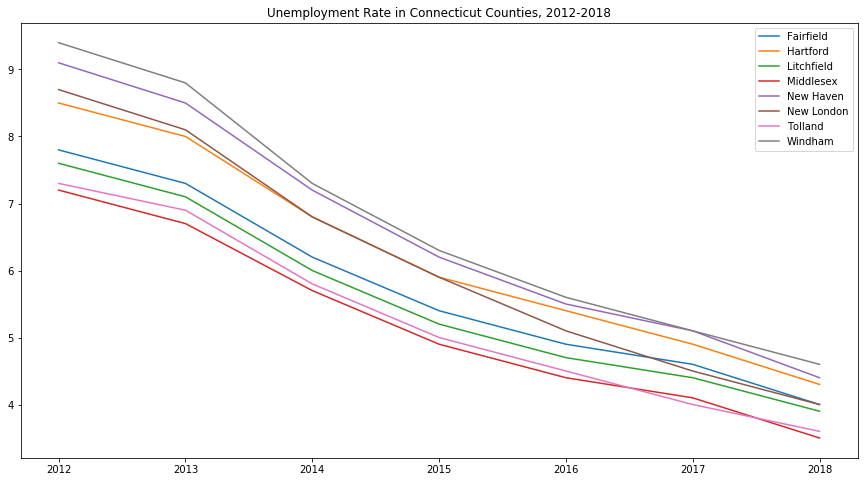

In [104]:
def unemployment_chart():
    plt.figure(figsize=(15,8))
    plt.title("Unemployment Rate in Connecticut Counties, 2012-2018")
    for jurisdiction in list(composite_info["Jurisdiction"].unique()):
        if jurisdiction != "Connecticut":
            df = composite_info[composite_info["Jurisdiction"] == jurisdiction]
            plt.plot(df["Year"], df["%Unemployed"], label=jurisdiction)
    plt.legend()
    
unemployment_chart()

Meanwhile, the poverty rate did not show a similarly consistent pattern. It fluctuated significantly in Middlessex and New London counties, and showed a 5-10% increase over the reported period in Middlesex, Fairfield, Tolland, and New London counties.

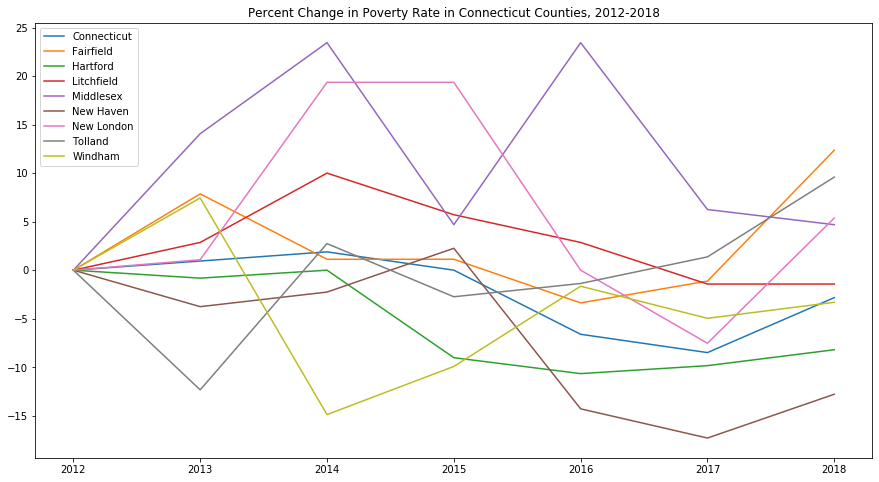

In [107]:
def poverty_chart():
    plt.figure(figsize=(15,8))
    plt.title("Percent Change in Poverty Rate in Connecticut Counties, 2012-2018")
    for jurisdiction in list(composite_info["Jurisdiction"].unique()):
        df = composite_info[composite_info["Jurisdiction"] == jurisdiction].reset_index()
        plt.plot(df["Year"], ((df["%inPoverty"] / df.loc[0]["%inPoverty"]) - 1) * 100, label=jurisdiction)
    plt.legend()
    
poverty_chart()

### Mean rates over the reported period

Mean economic indicators over the same time period do not show a consistent correlation with death rates.

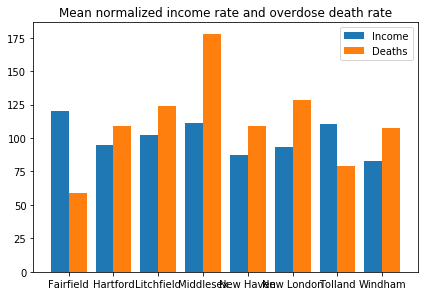

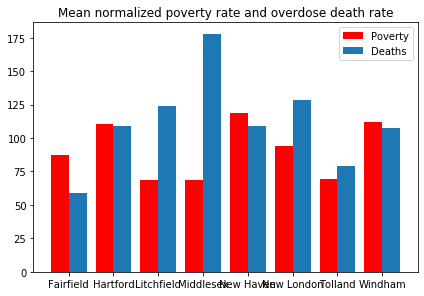

In [109]:
def mean_indicators_and_resident_deaths(switch="income"):
    counties = []
    income = []
    poverty = []
    resident_deaths = []
    
    for jurisdiction in list(composite_info["Jurisdiction"].unique()):
        if jurisdiction != "Connecticut":
            counties.append(jurisdiction)
            df = composite_info[composite_info["Jurisdiction"] == jurisdiction]
            income.append(df["incomeNorm"].mean())
            poverty.append(df["povNorm"].mean())
            resident_deaths.append(df["ResidentDeathsNorm"].mean())
            
    new_arr = [counties,income,poverty,resident_deaths]
    
    x = np.arange(len(counties))
    width = .4
    
    fig, ax = plt.subplots()
    if switch == "poverty":
        rects1 = ax.bar(x - width/2, poverty, width, label='Poverty', color="red")
    else:
        rects1 = ax.bar(x - width/2, income, width, label="Income")
    rects2 = ax.bar(x + width/2, resident_deaths, width, label='Deaths')
    
    ax.set_xticks(x)
    ax.set_xticklabels(counties)
    ax.legend()
    
    fig.tight_layout()
    
    plt.title(f'Mean normalized {switch} rate and overdose death rate')
    plt.show()
    
mean_indicators_and_resident_deaths()
mean_indicators_and_resident_deaths('poverty')

### County-by-County Plots

Plotting the per capita rate of overdose deaths (blue dashed line) against economic indicators (all normalized to state averages) does not show any crystal-clear year-by-year trends.

In [68]:
def unemployment_and_resident_deaths(county):
    df = composite_info[composite_info["Jurisdiction"] == county]
    plt.figure(figsize=(10,3))
    plt.plot(df["Year"],df["ResidentDeathsNorm"], label="Per Cap Resident Deaths", linestyle="--")
    plt.plot(df["Year"],df["unempNorm"], label="Unemployment")
    plt.plot(df["Year"],df["povNorm"], label="Poverty Rate")
    plt.plot(df["Year"],df["incomeNorm"], label="MedianIncome")
    plt.title(county)
    plt.legend()
    plt.show

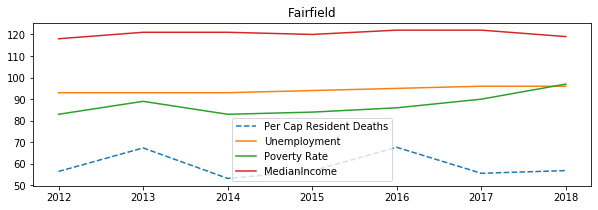

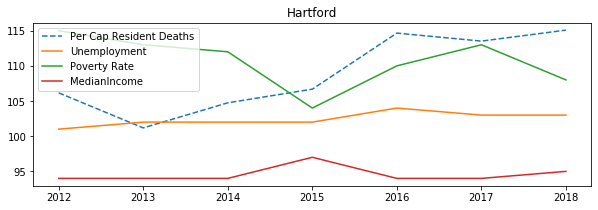

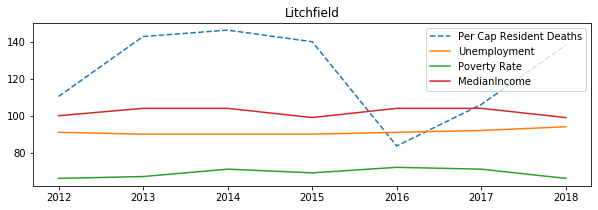

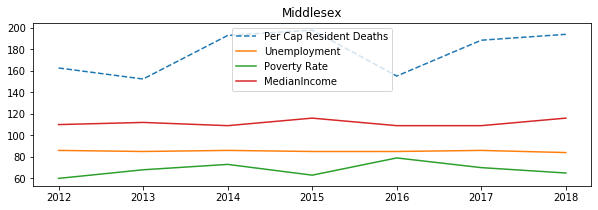

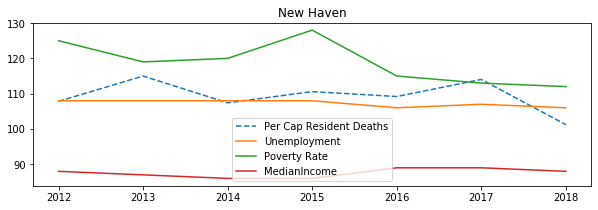

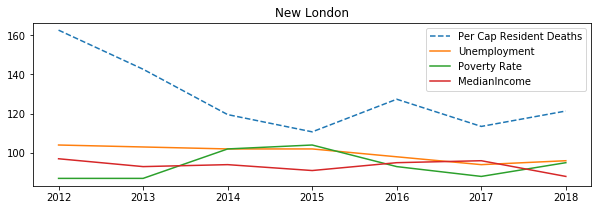

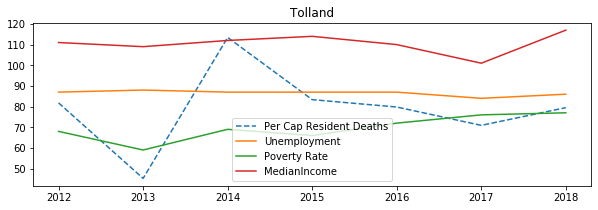

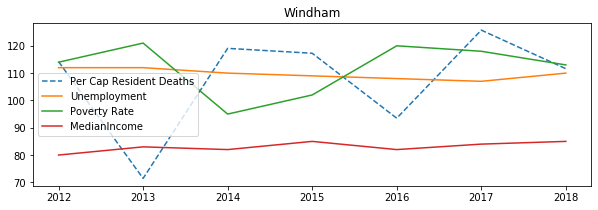

In [69]:
def unemp_res_deaths_all():
    for jurisdiction in list(composite_info["Jurisdiction"].unique()):
        if jurisdiction != "Connecticut":
            unemployment_and_resident_deaths(jurisdiction)
        
unemp_res_deaths_all()

## Conclusion

In conclusion, no conclusions could be drawn, aside from the fact that accidental overdose deaths rose throughout Connecticut between 2012 and 2018.